<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Korgun Dmitry, @tbb
    
## <center> Individual data analysis project

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_palette('Set3')

%matplotlib inline
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import mean_squared_error

# Dataset and features description 
### [Kaggle link](https://www.kaggle.com/c/elo-merchant-category-recommendation)

Elo - one of the largest payment brands in Brazil. In the dataset we can see clients who use Elo and their transactions. We need to predict the loyalty score for each card_id.

The description of the files are

* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format - contains all card_ids you are expected to predict for.
* historical_transactions.csv - up to 3 months' worth of historical transactions for each card_id
* merchants.csv - additional information about all merchants / merchant_ids in the dataset.
* new_merchant_transactions.csv - two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.

The *historical_transactions.csv* and *new_merchant_transactions.csv* files contain information about each card's transactions. *historical_transactions.csv* contains up to 3 months' worth of transactions for every card at any of the provided merchant_ids. *new_merchant_transactions.csv* contains the transactions at new merchants (merchant_ids that this particular card_id has not yet visited) over a period of two months.

*merchants.csv* contains aggregate information for each merchant_id represented in the data set.

#### Main dataset:

In [2]:
train = pd.read_csv('../../data/ELO/train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('../../data/ELO/test.csv', parse_dates=['first_active_month'])

train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [3]:
# columns description
pd.read_excel('../../data/ELO/Data_Dictionary.xlsx', sheet_name='train', header=2)

,Columns,Description
0,card_id,Unique card identifier
1,first_active_month,"'YYYY-MM', month of first purchase"
2,feature_1,Anonymized card categorical feature
3,feature_2,Anonymized card categorical feature
4,feature_3,Anonymized card categorical feature
5,target,Loyalty numerical score calculated 2 months af...


#### Historical Transactions:

In [4]:
hist = pd.read_csv('../../data/ELO/historical_transactions.csv')
hist.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [5]:
# columns description
pd.read_excel('../../data/ELO/Data_Dictionary.xlsx', sheet_name='history', header=2)

,Columns,Description
0,card_id,Card identifier
1,month_lag,month lag to reference date
2,purchase_date,Purchase date
3,authorized_flag,"Y' if approved, 'N' if denied"
4,category_3,anonymized category
5,installments,number of installments of purchase
6,category_1,anonymized category
7,merchant_category_id,Merchant category identifier (anonymized )
8,subsector_id,Merchant category group identifier (anonymized )
9,merchant_id,Merchant identifier (anonymized)


#### New merchant transactions

In [6]:
transaction = pd.read_csv('../../data/ELO/new_merchant_transactions.csv')
transaction.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [7]:
# columns description
pd.read_excel('../../data/ELO/Data_Dictionary.xlsx', sheet_name='new_merchant_period', header=2)

,Columns,Description
0,card_id,Card identifier
1,month_lag,month lag to reference date
2,purchase_date,Purchase date
3,authorized_flag,"Y' if approved, 'N' if denied"
4,category_3,anonymized category
5,installments,number of installments of purchase
6,category_1,anonymized category
7,merchant_category_id,Merchant category identifier (anonymized )
8,subsector_id,Merchant category group identifier (anonymized )
9,merchant_id,Merchant identifier (anonymized)


# Little bit preprocessing

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


As features are categorical we can change type to free some memory.

In [9]:
train['feature_1'] = train['feature_1'].astype('category')
train['feature_2'] = train['feature_2'].astype('category')
train['feature_3'] = train['feature_3'].astype('category')

test['feature_1'] = test['feature_1'].astype('category')
test['feature_2'] = test['feature_2'].astype('category')
test['feature_3'] = test['feature_3'].astype('category')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null category
feature_2             201917 non-null category
feature_3             201917 non-null category
target                201917 non-null float64
dtypes: category(3), datetime64[ns](1), float64(1), object(1)
memory usage: 5.2+ MB


# Exploratory data analysis and feature engineering

#### Check missed data

In [11]:
train.isna().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [12]:
test.isna().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

#### Target column
Let start analys with target value

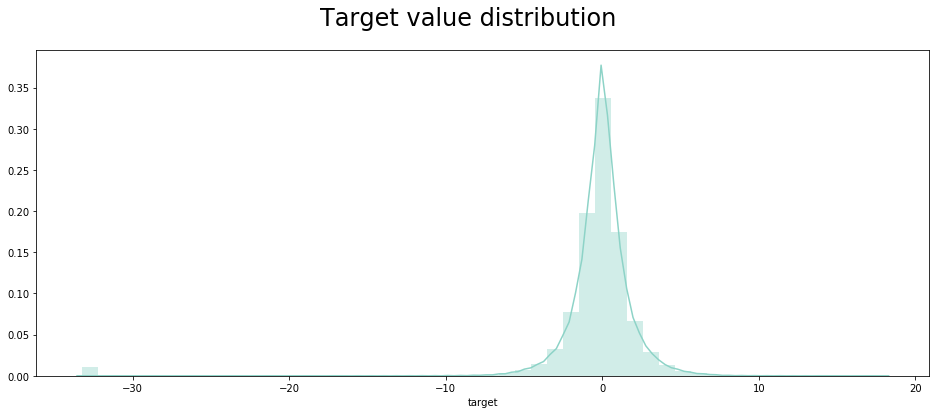

In [13]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.suptitle('Target value distribution', fontsize=24)
sns.distplot(train['target'], bins=50, ax=ax);

We can see that some of the loyalty values are far apart (less than -30) compared to others.

In [14]:
(train['target'] < -30).sum(), round((train['target'] < -30).sum() / train['target'].count(), 2)

(2207, 0.01)

So, there is 2207 rows (about 1% of the data), which has values different from the rest. Since the metric RMSE these rows might play an important role. So beware of them.

#### First Active Month
In this section, let see if there are any distribution change between train and test sets with respect to first active month of the card.

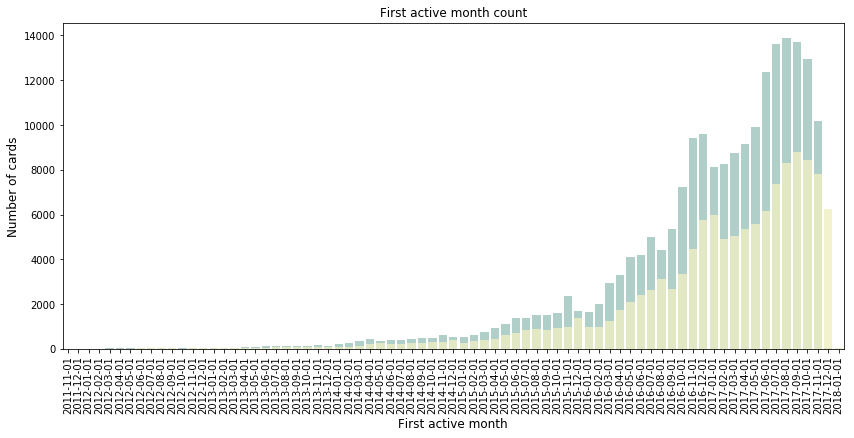

In [15]:
fig, ax = plt.subplots(figsize = (14, 6))

first_month_count_train = train['first_active_month'].dt.date.value_counts().sort_index()
sns.barplot(first_month_count_train.index,
            first_month_count_train.values,
            alpha=0.8, ax=ax, color='#96CAC0')

first_month_count_test = test['first_active_month'].dt.date.value_counts().sort_index()
sns.barplot(first_month_count_test.index,
            first_month_count_test.values,
            alpha=0.8, ax=ax, color='#F6F6BC')

plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title('First active month count')

plt.show()

Looks like the distribution is kind of similar between train and test set. So we need not really have to do time based split I think.

#### Anonymous features
In this section, let see if the other variables in the train dataset has good predictive power in finding the loyalty score.

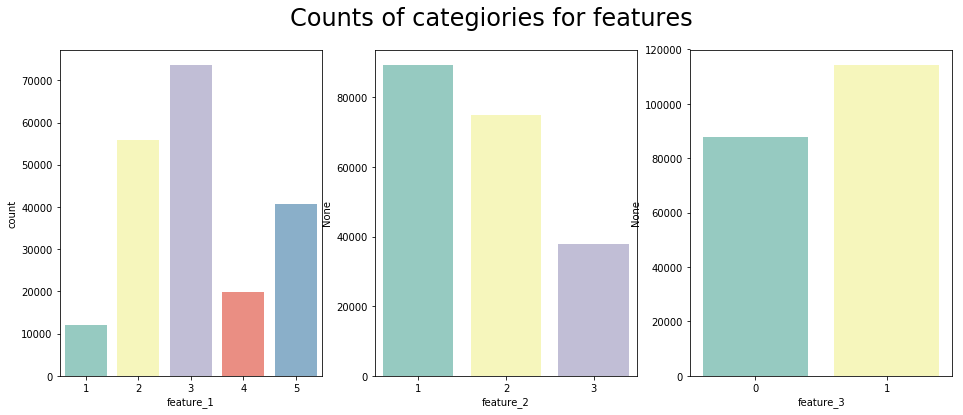

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Counts of categiories for features', fontsize=24)
sns.countplot(data=train, x='feature_1', ax=ax[0])
sns.countplot(data=train, x='feature_2', ax=ax[1]).set(ylabel=None)
sns.countplot(data=train, x='feature_3', ax=ax[2]).set(ylabel=None);

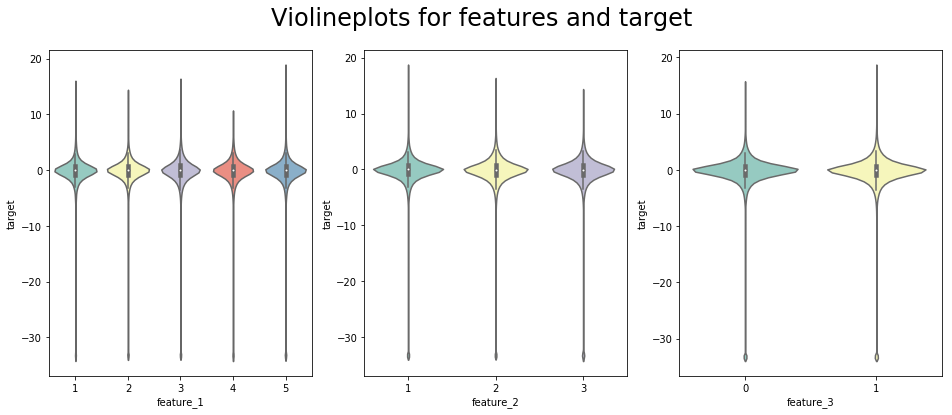

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
plt.suptitle('Violineplots for features and target', fontsize=24)
sns.violinplot(x='feature_1', y='target', data=train, ax=ax[0], title='feature_1', palette='Set3')
sns.violinplot(x='feature_2', y='target', data=train, ax=ax[1], title='feature_2', palette='Set3')
sns.violinplot(x='feature_3', y='target', data=train, ax=ax[2], title='feature_3', palette='Set3');

To the naked eyes, the distribution of the different categories in all three features look kind of similar. May be the models are able to find something here.

Now let us make some features based on the historical transactions and merge them with train and test set.

#### Number of Historical Transactions for the card


In [18]:
history_purchase_amount = hist.groupby('card_id')['purchase_amount'].size().reset_index()
history_purchase_amount.columns = ['card_id', 'history_purchase_amount']
train = pd.merge(train, history_purchase_amount, on='card_id', how='left')
test = pd.merge(test, history_purchase_amount, on='card_id', how='left')

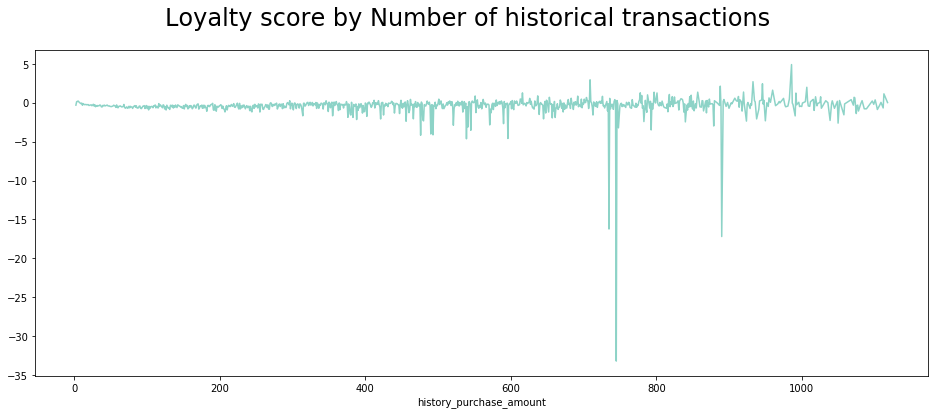

In [19]:
history_purchase_amount = train.groupby('history_purchase_amount')['target'].mean().sort_index()[:-50]
fig, ax = plt.subplots(figsize=(16, 6))
plt.suptitle('Loyalty score by Number of historical transactions', fontsize=24)
sns.lineplot(history_purchase_amount.index[::-1],
             history_purchase_amount.values[::-1],
             ax=ax);

Now let bin the count of historical transactions and then do some box plots to see the plots better.

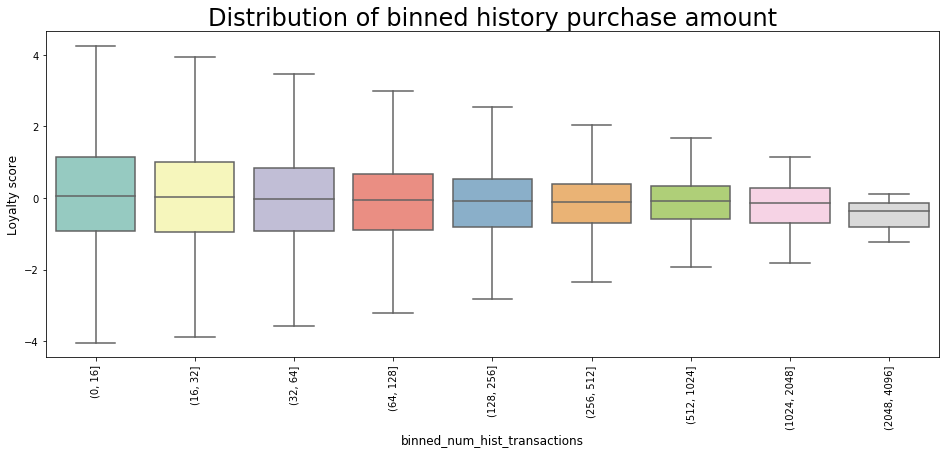

In [20]:
bins = [0] + [2 ** p for p in range(4, 13)]
train['binned_history_purchase_amount'] = pd.cut(train['history_purchase_amount'], bins)

plt.figure(figsize=(16, 6))
sns.boxplot(x='binned_history_purchase_amount', y='target', data=train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_hist_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Distribution of binned history purchase amount', fontsize=24)
plt.show()

#### Value of Historical Transactions
Check the value of the historical transactions for the cards and check the loyalty score distribution based on that.

In [21]:
gdf = hist.groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ['card_id', 
               'sum_history_purchase_amount', 
               'mean_history_purchase_amount', 
               'std_history_purchase_amount', 
               'min_history_purchase_amount', 
               'max_history_purchase_amount']
train = pd.merge(train, gdf, on='card_id', how='left')
test = pd.merge(test, gdf, on='card_id', how='left')

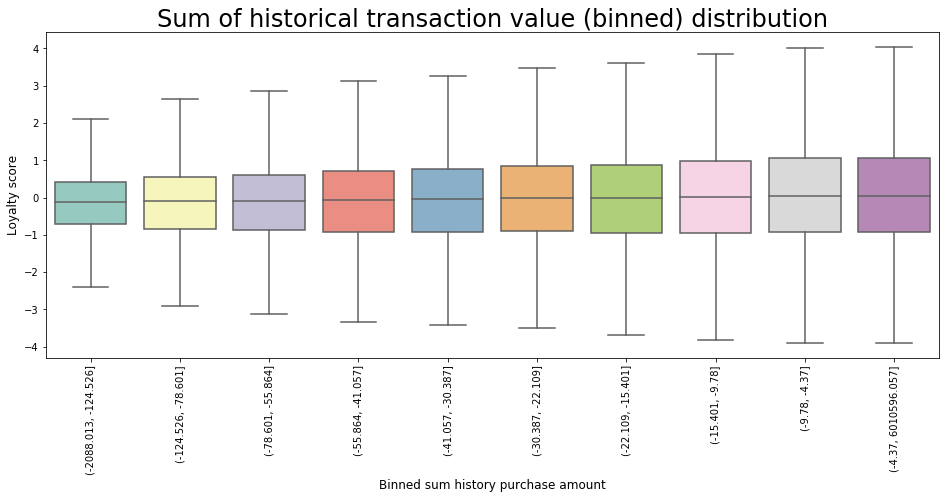

In [22]:
bins = np.percentile(train['sum_history_purchase_amount'], range(0,101,10))
train['binned_sum_history_purchase_amount'] = pd.cut(train['sum_history_purchase_amount'], bins)

plt.figure(figsize=(16, 6))
sns.boxplot(x='binned_sum_history_purchase_amount', y='target', data=train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('Binned sum history purchase amount', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Sum of historical transaction value (binned) distribution', fontsize=24)
plt.show()

As we could see, the loyalty score seem to increase with the `sum of historical transaction value`. This is expected. Now we can do the same plot with `Mean value of historical transaction`.

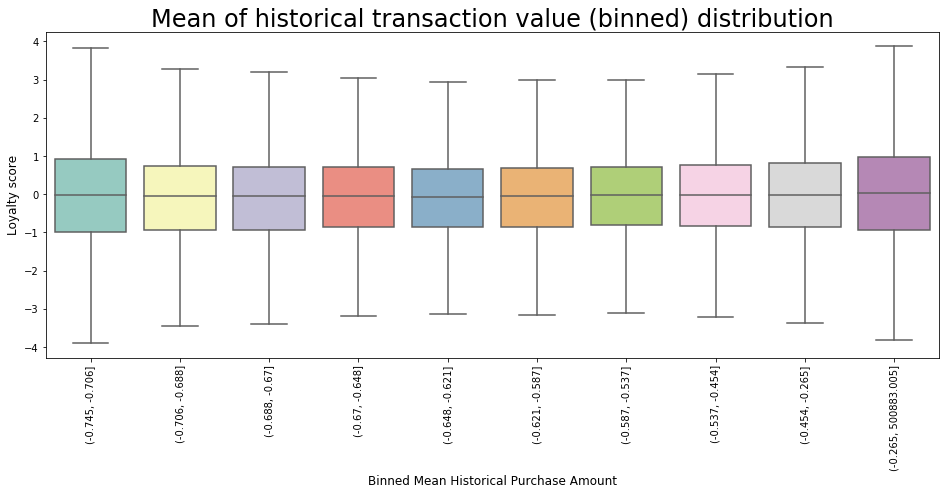

In [23]:
bins = np.percentile(train['mean_history_purchase_amount'], range(0,101,10))
train['binned_mean_history_purchase_amount'] = pd.cut(train['mean_history_purchase_amount'], bins)

plt.figure(figsize=(16, 6))
sns.boxplot(x='binned_mean_history_purchase_amount', y='target', data=train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('Binned Mean Historical Purchase Amount', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Mean of historical transaction value (binned) distribution', fontsize=24)
plt.show()

#### New Merchant Transactions
In this section, let look at the new merchant transactions data and do some analysis

In [24]:
gdf = transaction.groupby('card_id')['purchase_amount'].size().reset_index()
gdf.columns = ['card_id', 'transactions_count']
train = pd.merge(train, gdf, on='card_id', how='left')
test = pd.merge(test, gdf, on='card_id', how='left')

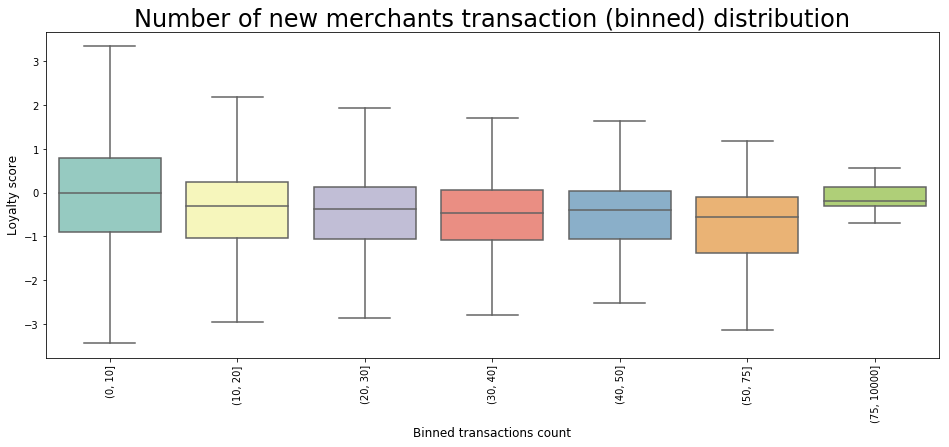

In [25]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]
train['binned_transactions_count'] = pd.cut(train['transactions_count'], bins)

plt.figure(figsize=(16, 6))
sns.boxplot(x='binned_transactions_count', y='target', data=train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('Binned transactions count', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Number of new merchants transaction (binned) distribution', fontsize=24)
plt.show()

Loyalty score seem to decrease as the number of new merchant transactions increases except for the last bin.

In [26]:
gdf = transaction.groupby('card_id')['purchase_amount'].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ['card_id', 
               'sum_transactions_count', 
               'mean_transactions_count', 
               'std_transactions_count', 
               'min_transactions_count', 
               'max_transactions_count']
train = pd.merge(train, gdf, on='card_id', how='left')
test = pd.merge(test, gdf, on='card_id', how='left')

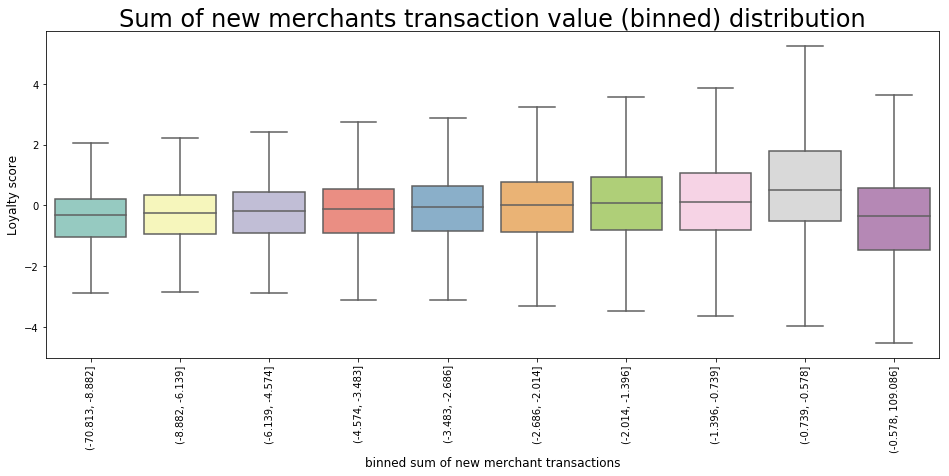

In [27]:
bins = np.nanpercentile(train['sum_transactions_count'], range(0,101,10))
train['binned_sum_transactions_count'] = pd.cut(train['sum_transactions_count'], bins)

plt.figure(figsize=(16, 6))
sns.boxplot(x='binned_sum_transactions_count', y='target', data=train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned sum of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Sum of new merchants transaction value (binned) distribution', fontsize=24)
plt.show()

Loyalty scores seem to increase with the increase in the sum of new merchant transaction values but for the last bin.

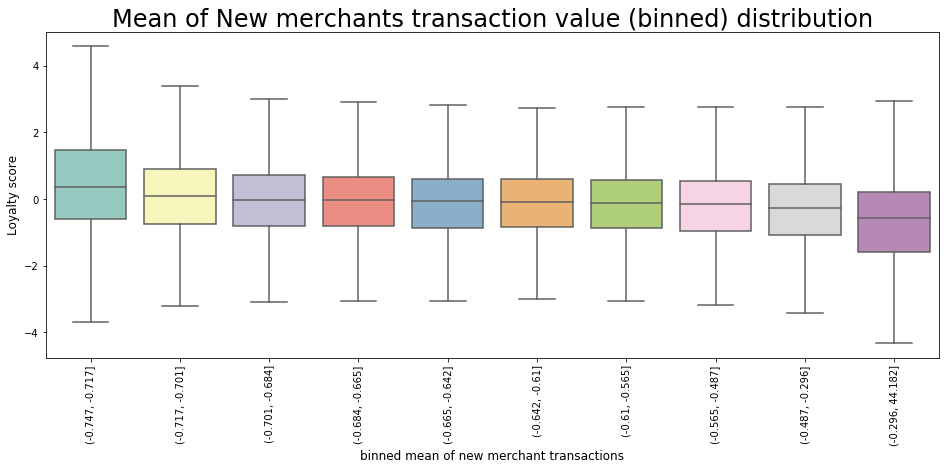

In [28]:
bins = np.nanpercentile(train['mean_transactions_count'], range(0,101,10))
train['binned_mean_transactions_count'] = pd.cut(train['mean_transactions_count'], bins)

plt.figure(figsize=(16, 6))
sns.boxplot(x='binned_mean_transactions_count', y='target', data=train, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned mean of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Mean of New merchants transaction value (binned) distribution', fontsize=24)
plt.show()

# Patterns, insights, pecularities of data

So, according to the results of the data analysis, the following conclusions can be drawn:
* There are no gaps in the train/tets data, but detailed information provided only for the last 3 month, so we have some missed data in generated features.
* There are outliers in the target variable that require additional analysis. This could be fraud blocking, or, for example, badly filled gaps.
* Judging by the dependence of loyalty on the number of purchases, loyalty grows with a sufficiently large number of purchases (> 75), and before that usually falls. This is expected, since those who stopped at a small number of purchases, as a rule, are not satisfied with the service.


# Data preprocessing

1 row in test data have missed `first_active_month`, so lets fix it.

In [29]:
test.loc[test['first_active_month'].isna(), 'first_active_month'] = test.loc[
    (test['feature_1'] == 5) & (test['feature_2'] == 2) & (test['feature_3'] == 1),
    'first_active_month'].min()

Fill in the data on `card_id` that do not have transactions over the past three months.

In [30]:
cols_to_fill = [
    'transactions_count', 'sum_transactions_count', 
    'mean_transactions_count', 'std_transactions_count',
    'min_transactions_count', 'max_transactions_count',    
]

train[cols_to_fill] = train[cols_to_fill].fillna(0)
test[cols_to_fill] = test[cols_to_fill].fillna(0)

# Add another several features

Here we add common date features.

In [31]:
max_date = train['first_active_month'].dt.date.max()
def process_main(df):
    date_parts = ['year', 'weekday', 'month']
    for part in date_parts:
        part_col = 'first_' + part
        df[part_col] = getattr(df['first_active_month'].dt, part).astype(int)
            
    df['elapsed_time'] = (max_date - df['first_active_month'].dt.date).dt.days
    
    return df

In [32]:
train = process_main(train)
test = process_main(test)

# Cross-validation, hyperparameter tuning

#### Baseline Model
Let build a baseline model using the features created so far. First of all we have to split data to train and validation sets.

In [33]:
cols_to_use = [
    'feature_1', 'feature_2', 'feature_3',
    'first_year', 'first_month', 'first_weekday', 'elapsed_time',
    'history_purchase_amount', 'sum_history_purchase_amount',
    'mean_history_purchase_amount', 'std_history_purchase_amount', 
    'min_history_purchase_amount', 'max_history_purchase_amount',
    'transactions_count', 'sum_transactions_count', 
    'mean_transactions_count', 'std_transactions_count',
    'min_transactions_count', 'max_transactions_count',
]

X_train, X_holdout, y_train, y_holdout = train_test_split(train[cols_to_use],
                                                          train['target'],
                                                          test_size=0.2)
X_test = test[cols_to_use]

Now that we have prepared data, we can delete raw data.

In [34]:
del train, test, hist, transaction

In [35]:
params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 1.0,
    'max_depth': 3,
    'max_features': 'sqrt',
    'n_iter_no_change': 5,
    'validation_fraction': 0.2,
    'tol': 0.00001,
    'random_state': 11,
}

Fit baseline model

In [36]:
%%time
model = GradientBoostingRegressor(**params)
model.fit(X_train[cols_to_use], y_train)

Wall time: 3.68 s


In [37]:
score = mean_squared_error(y_holdout, model.predict(X_holdout))
print(f'Baseline model score: {np.sqrt(score)}')

Baseline model score: 3.7450325832910587


In [38]:
fi = list(zip(cols_to_use, model.feature_importances_))
fi = pd.DataFrame(sorted(fi, key=lambda x: x[1], reverse=True), columns=['Feature', 'Importance'])

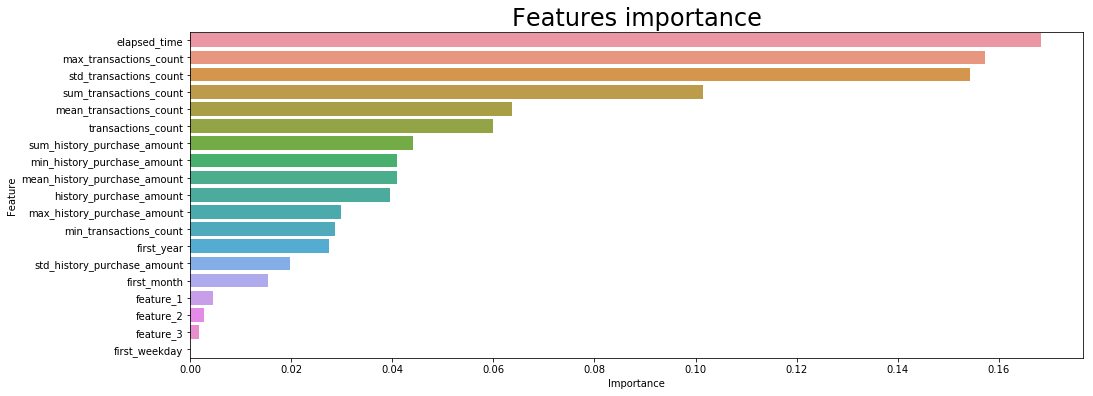

In [39]:
plt.figure(figsize=(16, 6))
sns.barplot(x='Importance', y='Feature', data=fi, orient='h')
plt.title('Features importance', fontsize=24);

# Validation and learning curves

Change params and tune `n_estimators` with validation curve.

In [40]:
params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'max_depth': 7,
    'max_features': 'sqrt',
    'n_iter_no_change': 5,
    'validation_fraction': 0.2,
    'tol': 0.00001,
    'random_state': 11,
}

In [41]:
def plot_validation_curve(model, X_train, y_train,
                          param, param_range, cv=3,
                          scoring='neg_mean_squared_error'):
    train_scores, test_scores = validation_curve(
        model, X_train, y_train, cv=cv,
        param_name=param, param_range=param_range,
        scoring=scoring, n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(16, 6))
    plt.title('Validation Curve')
    plt.xlabel('n_estimators')
    plt.ylabel('Score')

    plt.semilogx(param_range, train_scores_mean, label='Training score',
                 color='darkorange', lw=2)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color='darkorange', lw=2)
    plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
                 color='navy', lw=2)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color='navy', lw=2)
    plt.legend(loc='best')
    plt.show()

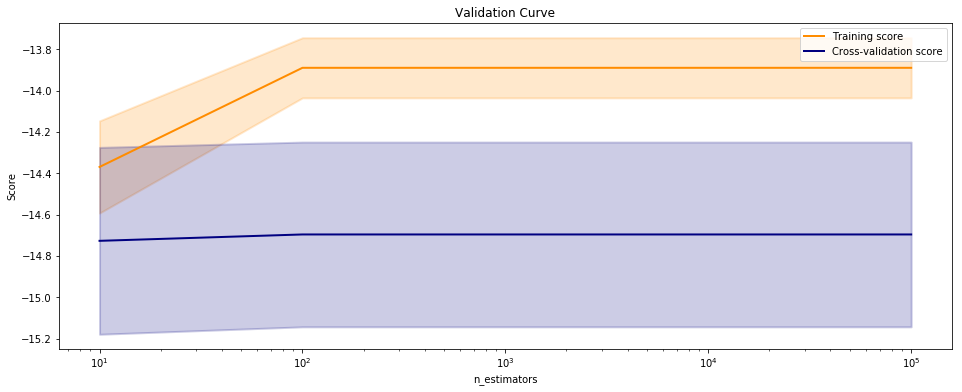

Wall time: 27 s


In [42]:
%%time
plot_validation_curve(GradientBoostingRegressor(**params),
                      X_train[cols_to_use], y_train,
                      param='n_estimators',
                      param_range=[10 ** x for x in range(1, 6)])

This validation curve poses two possibilities: first, that we do not have the correct param_range to find the best `n_estimators` and need to expand our search to larger values. The second is that other hyperparameters (such as `learning_rate` or `max_depth`, or even `subsample`) may have more influence on the default model than `n_estimators` by itself does. Although validation curves can give us some intuition about the performance of a model to a single hyperparameter, grid search is required to understand the performance of a model with respect to multiple hyperparameters.

In [43]:
def plot_learning_curve(model, X_train, y_train, cv=3,
                        train_sizes=None, scoring='neg_mean_squared_error',
                        random_state=11):
    if not train_sizes:
        train_sizes = np.linspace(.1, 1.0, 8)
        
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=cv,
        train_sizes=train_sizes,
        scoring=scoring,
        random_state=random_state,
        n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    
    plt.figure(figsize=(16, 6))
    plt.title('Learning curve')
    plt.xlabel('Training examples')
    plt.ylabel('Score') 
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Cross-validation score')

    plt.legend(loc='best')
    plt.show()

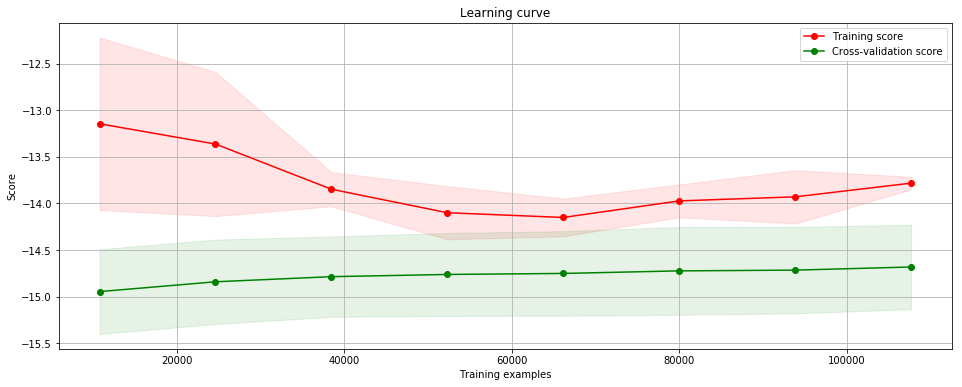

Wall time: 16.9 s


In [44]:
%%time
gbm = GradientBoostingRegressor(**params)
plot_learning_curve(gbm, X_train[cols_to_use], y_train)

This learning curve shows high test variability and a low score. We can see that the training and test scores have not yet converged, so potentially this model would benefit from more training data. Finally, this model does not suffer from error due to variance (the CV scores for the test data are more variable than for training data) so it is possible that the model is underfitting.

# Prediction for hold-out and test samples 

In [68]:
%%time
new_params = params
new_params['n_iter_no_change'] = None
new_params['n_estimators'] = 100
model = GradientBoostingRegressor(**new_params)
model.fit(X_train[cols_to_use], y_train)

Wall time: 5.89 s


In [69]:
score = mean_squared_error(y_holdout, model.predict(X_holdout))
print(f'Final model score: {np.sqrt(score)}')

Final model score: 3.7444562556838603


In [73]:
submission = pd.read_csv('../../data/ELO/sample_submission.csv')
submission['target'] = model.predict(X_test)
submission.to_csv('submit.csv', index=False)

# Metrics description

Predictions are scored on the root mean squared error. RMSE defined as:
$$ RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i) ^ 2 }$$
where $\hat{y}$ is the predicted loaylty score for each `card_id`, and $y$ is the actual loyalty score assigned to a `card_id`.

The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

# Model evaluation

The result - a fairly accurate model (the middle of the leaderboard) and having a small variance.

# Conclusions

To sum up, we have the model far away from perfect predictions and there is plenty room for improvement here. 
* First, it would be much better fine tune parameters (frankly, I stoped wait the end of GridSearch after second night). 
* Second, creating more informative features and try other models (e.g. xgboost, LightGBM, CatBoost).

So, the time has finish. Thank you for your attentions!